# Data ingestion and transformation notebook

This notebook uses the data ingestion standard and run the transformations and feature engineering.

In [1]:
import json
import numpy as np
import pandas as pd
import os
import zipfile
from zipfile import ZipFile
from datetime import datetime, date
import time
import requests

In [2]:
%reload_ext autoreload
%autoreload 2

main_time_counter = time.time()

In [3]:
# Helper functions for feature engineering:

def decode_stacked_json(stacked_json_string, pos=0, decoder=json.JSONDecoder()):
    """Yield multiple JSON objects and restart parsing from the previous position
    Input must be of the form: {'key1': value1, 'key2': value2}{'key3': value3, 'key4': value4"""
    while True:
        try:
            json_object, pos = decoder.raw_decode(stacked_json_string, pos)
        except json.JSONDecodeError:
            break
        yield json_object
       
        
def after_wake_exercise(class_5min,bedtime_end):
    """returns the number of minutes with medium to high MET scores 
    within the first 3 hours of wake-time as a proxy for whether or not exercise 
    occurs after waking up"""
    if isinstance(class_5min,float) or isinstance(bedtime_end, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))
        #--take the timestamp from the datetime string, extracts hh:mm data, and converts to a number--#
        wake_hr_min = int(''.join(bedtime_end.split('T')[1][0:5].split(':')))
        #---calculate minutes lapsed since 4am and wake up time---#
        #---rescale minutes into 5 minute intervals to find the number of elements at which to offset class_5min--#
        offset = int(((wake_hr_min - 400)/100)*(60/5))

        #subset observations between wake up and 3 hrs post wake up (24*5=120 min)
        morning_obs = class_5min_list[offset:offset+36]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in morning_obs if obs >=3])*5
        return total_min


def before_sleep_exercise(class_5min,bedtime_start):
    """returns the number of minutes with medium to high MET scores 
    within the last 3 hours of wake-time as a proxy for whether or not exercise 
    occurs in the evening close to bedtime"""
    if isinstance(class_5min,float) or isinstance(bedtime_start, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))
        #--take the timestamp from the datetime string, extracts hh:mm data, and converts to a number--#
        sleep_hr_min = int(''.join(bedtime_start.split('T')[1][0:5].split(':')))
        #---calculate minutes lapsed since 4am and wake up time---#
        #---rescale minutes into 5 minute intervals to find the number of elements at which to offset class_5min--#
        offset = int(((sleep_hr_min - 400)/100)*(60/5))

        #subset observations 3 hours before sleep time
        evening_obs = class_5min_list[offset-36:offset]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in evening_obs if obs >=3])*5
        return total_min


def noon_exercise(class_5min):
    """returns the number of minutes with medium to high MET scores 
    between noon and two local time"""
    if isinstance(class_5min,float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))

        #---calculate minutes lapsed since 4am and 12 (8*12 (5min intervasl in an hr)---#

        offset = 96

        #subset observations between noon and 2 pm
        noon_obs = class_5min_list[offset:offset+24]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in noon_obs if obs >=3])*5
        return total_min
 
    
def evening_exercise(class_5min):
    """returns the number of minutes with medium to high MET scores 
    between noon and two local time"""
    if isinstance(class_5min, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))

        #---calculate minutes lapsed since 4am and 5pm (13*12) --there are 12 5min intervasl in an hr---#

        offset = 156

        #subset observations between 5pm and 7 pm post wake up
        eve_obs = class_5min_list[offset:offset+24]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in eve_obs if obs >=3])*5
        return total_min


def after_midnight(timestamp_str):
    """indicator for whether or not bedtime started after midnight (in early am hours)"""
    try:
        day, hour = timestamp_str.split('T')
        hr = int(hour[0:2]) #extract hr from timestamp
        if 0 <= hr < 6:
            return 1
        else:
            return 0
    except:
        return np.nan

def age_bin(e):
    """Bins: 20s, 30s, 40s, and 50s +"""
    if  20 <= e < 30:
        return "20s"
    elif 30 <= e < 40:
        return "30s"
    elif 40 <= e < 50:
        return "40s"
    elif e > 50:
        return "50s plus"
    else:
        return np.nan
   
    
def height_bin(e):
    """Bins: 0, 150, 160, 170, 180, 190. In centimeters """
    if  0 < e < 150:
        return "less than 150 cm"
    elif 150 <= e <= 160:
        return "150s"
    elif 160 <= e <= 170:
        return "160s"
    elif 170 <= e <= 180:
        return "170s"
    elif 180 <= e <= 190:
        return "180s"
    elif e > 190:
        return "greater than 190 cm"
    else:
        return np.nan
    
    
def weight_bin(e):
    """Bins: 0, 65, 80, 95. In kilograms"""
    if  0 < e <=65:
        return "less than 65 kg"
    elif 65 <= e <= 80:
        return "65 to 80 kg"
    elif 80 <= e <= 95:
        return "80 to 95 kg"
    elif e > 95:
        return "more than 95 kg"
    else:
        return np.nan

def experiments_recategorize(e):
    '''helper function to recategorize experiment types:
    broader categories will be Magnesium, Chamomile tea, Meditation and Other'''
    if pd.isnull(e):
        return 'None'
    elif 'Meditat' in e:
        return 'Meditation'
    elif 'Magnesium' in e:
        return 'Magnesium'
    elif 'Chamomile' in e:
        return 'Chamomile Tea'
    else:
        return 'Other'

In [4]:
full_path = 'data_ingestion/{}'.format(date.today().strftime('%d%m%Y'))
os.makedirs(full_path, exist_ok=True)

# create a simple "log file" on the log ingestion directory. Can be helpful to debug and later on for feature monitoring.
log_file = open(full_path + '/log.txt', 'a+')
log_file.write(time.asctime() + ' - Starting data ingestion process\n')

# if a data file exists, load it, otherwise, create the directory, download a new one and load the DFs:
if not os.path.isfile(full_path + '/raw_dataset.zip'):    
    start = time.time() # time the data ingestion from Memento
    log_file.write(time.asctime() + ' - Day file not found. Starting data download\n')
    
    # try: 
    ACCESS_TOKEN = ##ENVIRONMENT VARIABLE HERE##
    headers = {'Authorization': 'Bearer ' + ACCESS_TOKEN }
    URL = "https://api.mementolabs.io/data/dataset"
    # changed this code to deal with streaming json from 10/20/2019 on. Must double check if this will be the final 
    # format
    data = requests.get(URL, headers=headers).content.decode(encoding='utf-8')

    # save the raw data to disk as zip it to allow re-processing without new download
    zip_file = full_path + '/raw_dataset.zip'
    zipObj = ZipFile(zip_file, 'w', compression=zipfile.ZIP_DEFLATED)
    zipObj.writestr('raw_dataset.txt', data)
    zipObj.close()

    # print('total run time:',time.time() - start)
    log_file.write(time.asctime() + ' - JSON File downloaded and saved. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')
    

In [5]:
# define intermediate data frames:
users = pd.DataFrame()
sleep = pd.DataFrame()
readiness = pd.DataFrame()
activity = pd.DataFrame()
experiments = pd.DataFrame()
experiments2 = pd.DataFrame()

start = time.time()
raw_data = str(zipfile.ZipFile(full_path + '/raw_dataset.zip').read('raw_dataset.txt'), encoding='utf-8')
log_file.write(time.asctime() + ' - raw data file loaded. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')

start = time.time()
log_file.write(time.asctime() + ' - creating feature space\n')

active_user_counter = 0
xp_counter = 0

for user_json in decode_stacked_json(raw_data):
    # in the stacked json file, each json object corresponds to all data of one user. So here I will perform all 
    # feature transformation that are user-dependent before I append the whole user data to a final data frame.
    user_user = pd.DataFrame.from_records([user_json['userInfo']['userInfo']])
    
    try: # user signup date may be useful to define if a user model is relevant or not:
        user_user['signupDate'] = pd.to_datetime(user_json['signupDate'])
    except KeyError:
        user_user['signupDate'] = np.nan

    # one hot encode gender data:
    try:
        user_user['gender'] = np.where(user_user['gender'] == 'male', True, False)
    except KeyError:
        user_user['gender'] = np.nan

    user_user.rename(columns={'gender':'is_male'}, inplace=True)

    try:
        user_user['age'] = user_user['age']
    except KeyError:
        user_user['age'] = np.nan

    try:
        user_user['height'] = user_user['height']
    except KeyError:
        user_user['height'] = np.nan

    try:
        user_user['weight'] = user_user['weight']
    except KeyError:
        user_user['weight'] = np.nan

    # send to a final users data frame:
    users = users.append(user_user)

    # skip users without sleep records (strictly experiment users, or users of other hardware)
    if len(user_json['sleep']) == 0: continue
    active_user_counter += 1

    # unpack data for each user in a specific data frame
    user_sleep = pd.DataFrame.from_records([i for i in user_json['sleep']])
    user_readiness = pd.DataFrame.from_records([i for i in user_json['readiness']])
    user_activity = pd.DataFrame.from_records([i for i in user_json['activity']])

    # each DF has a `score` feature. Renaming to avoid later confusion:
    user_sleep.rename(columns = {'score':'sleep_score'}, inplace=True)
    user_activity.rename(columns = {'score':'activity_score'}, inplace=True)
    user_readiness.rename(columns = {'score':'readiness_score'}, inplace=True)

    #### ---------- SLEEP FEATURES ----------- ####
    # sleep features normalizing and transformations:
    user_sleep['awake_norm'] = user_sleep['awake']/user_sleep['duration']
    user_sleep['deep_norm'] = user_sleep['deep']/user_sleep['duration']
    user_sleep['light_norm'] = user_sleep['light']/user_sleep['duration']
    user_sleep['onset_latency_norm'] = user_sleep['onset_latency']/user_sleep['duration']
    user_sleep['rem_norm'] = user_sleep['rem']/user_sleep['duration']
    user_sleep['restless_norm'] = user_sleep['light']/100

    # bins for sleep score to Shiraz's models:
    bins = [0, 75, 85, 100]
    names = ['fair', 'good', 'greate']
    user_sleep['good_sleep'] = pd.cut(user_sleep['sleep_score'], bins=bins, labels=names)

    # creating new sleep features:
    user_sleep['summary_date'] = pd.to_datetime(user_sleep['summary_date'])
    user_sleep['user_id'] = user_user['user_id'][0]
    user_sleep['user_date'] = user_sleep['user_id'] + '|' + user_sleep['summary_date'].astype('str')

    user_sleep.set_index('summary_date', inplace = True, drop=False)

    # build D - 1 and D - 2 scores:
    user_sleep['sleep_score_D-1'] = user_sleep['sleep_score'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['sleep_score_D-2'] = user_sleep['sleep_score'].shift()[user_sleep.index.shift(1,freq='2D')]
    user_sleep['deep_D-1'] = user_sleep['deep'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['deep_D-2'] = user_sleep['deep'].shift()[user_sleep.index.shift(1,freq='2D')]
    user_sleep['rem_D-1'] = user_sleep['rem'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['rem_D-2'] = user_sleep['rem'].shift()[user_sleep.index.shift(1,freq='2D')]

    # build 7, 14, and 21 rolling average scores:
    user_sleep['rol_sleep_score_7d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    # shifted 7 day score rolled feature. This is target feature to predict your average 7 days ahead
    user_sleep['avg_sleep_score_next_week'] = user_sleep['rol_sleep_score_7d'].shift(-1,freq='7D')

    user_sleep['rol_sleep_score_14d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=14, min_periods=10).mean()
    user_sleep['rol_sleep_score_21d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=21, min_periods=17).mean()

    # build other 7-day rolling features for peter's models later:
    user_sleep['rol_bedtime_end_delta_7d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                            window=7, min_periods=3).mean()
    user_sleep['rol_bedtime_start_delta_7d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                    window=7, min_periods=3).mean()
    user_sleep['rol_onset_latency_7d'] = pd.DataFrame.rolling(user_sleep['onset_latency'].shift(1, freq='1D'),
                                                              window=7, min_periods=3).mean()
    user_sleep['rol_duration_7d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                         window=7, min_periods=3).mean()

    # build is_traveling
    user_sleep['is_traveling'] = np.where(user_sleep['timezone'] == 
                                                    user_sleep['timezone'].value_counts().idxmax(), False, True)
    
    user_sleep['tz_delta'] = (user_sleep['timezone'] - user_sleep['timezone'].value_counts().idxmax()) / (-60)
    
    # build rol_bedtime_start_21d
    user_sleep['rol_bedtime_start_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    # build avg_bedtime_start_delta, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_bedtime_start_std_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['bedtime_start_dev'] = (user_sleep['bedtime_start_delta'] - user_sleep['rol_bedtime_start_21d'])/\
                                      user_sleep['rol_bedtime_start_std_21d']

    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] >= 0, 
                                                        np.ceil(user_sleep['bedtime_start_dev']),
                                                        np.floor(user_sleep['bedtime_start_dev']))
    # cap standard deviations to -3 or +3:
    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] <= -3,-3, user_sleep['bedtime_start_dev'])

    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] >= 3,3,
                                                        user_sleep['bedtime_start_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['bedtime_start_dev'])

    user_sleep.rename(columns = { 'bedtime_start_dev_-3.0':'bedtime_start_dev-3', 
                                  'bedtime_start_dev_-2.0':'bedtime_start_dev-2', 
                                  'bedtime_start_dev_-1.0': 'bedtime_start_dev-1',
                                  'bedtime_start_dev_1.0': 'bedtime_start_dev+1',
                                  'bedtime_start_dev_2.0': 'bedtime_start_dev+2',
                                  'bedtime_start_dev_3.0': 'bedtime_start_dev+3'},
                                  inplace = True)

    user_sleep.drop(labels = ['rol_bedtime_start_21d','rol_bedtime_start_std_21d'], axis = 1, inplace = True)

    # build avg_bedtime_end_delta, create dummy variables for deviation. (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_bedtime_end_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    user_sleep['rol_bedtime_end_std_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['bedtime_end_dev'] = (user_sleep['bedtime_end_delta'] - user_sleep['rol_bedtime_end_21d'])/\
                                    user_sleep['rol_bedtime_end_std_21d']

    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] >= 0, 
                                             np.ceil(user_sleep['bedtime_end_dev']),
                                             np.floor(user_sleep['bedtime_end_dev']))
    # cap standard deviations to -3 or +3:
    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] <= -3,-3,
                                             user_sleep['bedtime_end_dev'])

    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] >= 3,3,
                                             user_sleep['bedtime_end_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['bedtime_end_dev'])

    user_sleep.rename(columns = {'bedtime_end_dev_-3.0':'bedtime_end_dev-3', 
                                 'bedtime_end_dev_-2.0':'bedtime_end_dev-2', 
                                 'bedtime_end_dev_-1.0': 'bedtime_end_dev-1',
                                 'bedtime_end_dev_1.0': 'bedtime_end_dev+1',
                                 'bedtime_end_dev_2.0': 'bedtime_end_dev+2',
                                 'bedtime_end_dev_3.0': 'bedtime_end_dev+3'},
                                 inplace = True)

    user_sleep.drop(labels = ['rol_bedtime_end_21d','rol_bedtime_end_std_21d'], axis = 1, inplace = True)

    # build avg_duration, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_duration_21d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    user_sleep['rol_duration_std_21d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['duration_dev'] = (user_sleep['duration'] - user_sleep['rol_duration_21d'])/\
                                 user_sleep['rol_duration_std_21d']

    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] >= 0, 
                                          np.ceil(user_sleep['duration_dev']),
                                          np.floor(user_sleep['duration_dev']))

    # cap standard deviations to -3 or +3:
    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] <= -3,-3, user_sleep['duration_dev'])

    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] >= 3,3, user_sleep['duration_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['duration_dev'])

    user_sleep.rename(columns = {'duration_dev_-3.0':'duration_dev-3', 
                              'duration_dev_-2.0':'duration_dev-2', 
                              'duration_dev_-1.0':'duration_dev-1',
                              'duration_dev_1.0': 'duration_dev+1',
                              'duration_dev_2.0': 'duration_dev+2',
                              'duration_dev_3.0': 'duration_dev+3'},
                              inplace = True)

    user_sleep.drop(labels = ['rol_duration_21d','rol_duration_std_21d'], axis = 1, inplace = True)

    # build dummy to day of the week.
    user_sleep['weekday'] = user_sleep['summary_date'].dt.weekday

    # build is_workday
    user_sleep['is_workday'] = np.where(user_sleep['weekday'] < 5, 1, 0)

    # one-hot encode weekdays
    user_sleep = pd.get_dummies(user_sleep, columns=['weekday'])

    user_sleep.rename(columns = {'weekday_0':'weekday_mon', 
                              'weekday_1':'weekday_tue', 
                              'weekday_2': 'weekday_wed',
                              'weekday_3': 'weekday_thu',
                              'weekday_4': 'weekday_fri',
                              'weekday_5': 'weekday_sat',
                              'weekday_6': 'weekday_sun'}, 
                              inplace = True)

    #rolling actionable sleep features
    sleep_vars_to_roll = ['onset_latency','duration','is_traveling','score_disturbances']
    
    for feature in sleep_vars_to_roll :
        user_sleep['rol_' + feature + '_7d'] = pd.DataFrame.rolling(user_sleep[feature].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    
    
    #---Week-over-Week sleep behavior changes as proxy for sleep routine---#
    user_sleep['rol_onset_latency_7d_WoW'] = user_sleep['rol_onset_latency_7d'].pct_change(periods=7)
    user_sleep['rol_duration_7d_WoW'] = user_sleep['rol_duration_7d'].pct_change(periods=7)
    user_sleep['rol_score_disturbances_7d_WoW'] = user_sleep['rol_score_disturbances_7d'].pct_change(periods=7)
    user_sleep['rol_bedtime_start_delta_7d_WoW'] = user_sleep['rol_bedtime_start_delta_7d'].pct_change(periods=7)
    
    #sleep routine as the mean absolute value of WoW variables
    user_sleep['sleep_routine_score'] = (
    np.absolute(user_sleep['rol_onset_latency_7d_WoW']) + 
    np.absolute(user_sleep['rol_duration_7d_WoW']) +
    np.absolute(user_sleep['rol_score_disturbances_7d_WoW'])+
    np.absolute(user_sleep['rol_bedtime_start_delta_7d_WoW']))/4
    
    user_sleep.set_index('user_date', inplace = True)
    sleep = sleep.append(user_sleep)


    #### ---------- ACTIVITY FEATURES ----------- ####
    # Creating the new activity related features. Because several activity features depends on user info and/or 
    # sleep features, I will add the features needed here:
    user_activity['user_date'] = user_user['user_id'][0] + '|' + user_activity['summary_date'].astype('str')

    user_activity['age'] = user_user['age'][0]
    user_activity['height'] = user_user['height'][0]
    user_activity['weight'] = user_user['weight'][0]
    user_activity['is_male'] = user_user['is_male'][0]

    user_activity['summary_date'] = pd.to_datetime(user_activity['summary_date'])   
    user_activity = user_activity.merge(user_sleep[['bedtime_start', 'bedtime_end', 'summary_date']], 
                                        on='summary_date', how='left')

    user_activity.set_index('summary_date', inplace = True, drop=False)

    user_activity['met_min_medium_plus'] = user_activity['met_min_medium'] + \
                                                    user_activity['met_min_high']

    user_activity['age_bin'] = user_activity['age'].apply(age_bin)
    user_activity['height_bin'] = user_activity['height'].apply(height_bin)
    user_activity['weight_bin'] = user_activity['weight'].apply(weight_bin)
    user_activity['sleep_afterMidnight'] = user_activity['bedtime_start'].apply(after_midnight)
    user_activity['afterwake_exercise_min'] = [after_wake_exercise(c,b) for c,b in \
                                               zip(user_activity['class_5min'],
                                                   user_activity['bedtime_end'])]
    user_activity['beforesleep_exercise_min'] = [before_sleep_exercise(c,b) for c,b in \
                                                 zip(user_activity['class_5min'],
                                                     user_activity['bedtime_start'])]
    user_activity['noon_exercise_min'] = user_activity['class_5min'].apply(noon_exercise)
    user_activity['eve_exercise_min'] = user_activity['class_5min'].apply(evening_exercise)

    # actionable activity variables that will be rolled within a 7 day window
    activity_vars_to_roll = ['cal_total', 'high', 'medium','steps','inactive', 
                             'non_wear', 'activity_score','met_min_medium','sleep_afterMidnight',
                             'met_min_high', 'met_min_medium_plus','score_move_every_hour',
                             'score_stay_active', 'beforesleep_exercise_min',
                             'afterwake_exercise_min','noon_exercise_min', 'eve_exercise_min']

    for feature in activity_vars_to_roll :
        user_activity['rol_' + feature + '_7d'] = pd.DataFrame.rolling(user_activity[feature].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    
    #---Week-over-Week activity behavior changes as proxy for activity routine---#
    #note; these variables are already recorded on a last 7 day average per API so we didn't need to roll them
    user_activity['score_training_frequency_WoW'] = user_activity['score_training_frequency'].pct_change(periods=7)
    user_activity['score_training_volume_WoW'] = user_activity['score_training_volume'].pct_change(periods=7)
    user_activity['score_meet_daily_targets_WoW'] = user_activity['score_meet_daily_targets'].pct_change(periods=7)
    user_activity['score_recovery_time_WoW'] = user_activity['score_recovery_time'].pct_change(periods=7)
    
    #activity routine as the mean absolute value of WoW variables
    user_activity['activity_routine_score'] = (
    np.absolute(user_activity['score_training_frequency_WoW']) + 
    np.absolute(user_activity['score_training_volume_WoW']) +
    np.absolute(user_activity['score_meet_daily_targets_WoW'])+
    np.absolute(user_activity['score_recovery_time_WoW']))/4


    user_activity.set_index('user_date', inplace = True)
    activity = activity.append(user_activity)


    #### ---------- READINESS FEATURES ----------- ####
    # As we are not doing any transformation in the readiness data frame, append directly to the final one:
    user_readiness['user_date'] = user_user['user_id'][0] + '|' + user_readiness['summary_date'].astype('str')
    user_readiness.set_index('user_date', inplace=True)
    readiness = readiness.append(user_readiness)

    #### ---------- EXPERIMENTS FEATURES ----------- ####
    # Not all users had experiments done:
    if len(user_json['previousExperiments']) != 0:
    # extract and flattens only the features needed: date, treatment, effect, and if if is a baseline date.
    # NOTE: In Memento one experiment have one treatment, but can have multiple effects, however we are not interested
    #       in the intermediate effect, but on the effect on final sleep score. Therefore, we will ignore the effects
    #       the users set and incorporate the experiments to the main data frame.
      
        user_experiments = pd.DataFrame.from_records([i for i in user_json['previousExperiments']])
        xp_counter += len(user_json['previousExperiments'])
    
        try:
            treatment_randomized = pd.io.json.json_normalize(user_experiments.design[0]).isRandomized[0]
        except:
            treatment_randomized = 0
        
        # parse experiment types:
        experiment_type = user_experiments.experimentName[0].split('(')[0]
        
        # unroll checkIns object
        checkIns = pd.DataFrame()
        checkIns = pd.io.json.json_normalize(user_experiments.checkIns[0])
        
        # add experiment randomization, type, and user_ids to checkins
        checkIns['treatment_randomized'] = treatment_randomized
        checkIns['experiment_type'] = experiment_type
        checkIns['user_id'] = user_user['user_id'][0]
        
        # filter out only the necessary columns (helps the join later)
        checkIns = checkIns.filter(['date','user_id','treatment_randomized','experiment_type','compliance'])
    
        checkIns['user_date'] = checkIns['user_id'] + '|' + checkIns['date'].astype('str')
        checkIns.set_index('user_date', inplace=True)
    
        experiments = experiments.append(checkIns)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [6]:
# log the time and main descriptive statistics of the final datasets for data governance purposes
log_file.write(time.asctime() + ' - Feature space created. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')
log_file.write(time.asctime() + '     - Total active users: ' + str(active_user_counter) + '\n')
log_file.write(time.asctime() + '     - ACTIVITY data frame shape: ' + str(activity.shape) + '\n')
log_file.write(time.asctime() + '     - SLEEP data frame shape: ' + str(sleep.shape) + '\n')
log_file.write(time.asctime() + '     - READINESS data frame shape: ' + str(readiness.shape) + '\n')
log_file.write(time.asctime() + '     - EXPERIMENTS data frame shape: ' + str(experiments.shape) + '\n')
log_file.write(time.asctime() + '       - finished EXPERIMENTS count: ' + str(xp_counter) + '\n')
log_file.write(time.asctime() + '       - finished EXPERIMENTS user-days: ' + str(experiments.shape[0]) + '\n')

69

In [7]:
start = time.time()

# Save each DF as a csv file (case needed to work on a single file in teh future
users_file_path = full_path + '/users_data.csv'
sleep_file_path = full_path + '/sleep_data.csv'
readiness_file_path = full_path + '/readiness_data.csv'
activity_file_path = full_path + '/activity_data.csv'
df_gold_file_path = full_path + '/gold.csv'
experiments_file_path = full_path + '/experiments.csv'

users.to_csv(users_file_path, index=None, encoding='utf-8')
sleep.to_csv(sleep_file_path, index_label='user_date', encoding='utf-8')
readiness.to_csv(readiness_file_path, index_label='user_Date', encoding='utf-8')
activity.to_csv(activity_file_path, index_label='user_Date', encoding='utf-8')
experiments.to_csv(experiments_file_path, index=None, encoding='utf-8')

# Drop duplicate columns and merge all dfs in a big "gold" df. Will keep only one of the summary dates (readiness)
readiness.drop(['period_id'], axis=1, inplace=True)
sleep.drop(['summary_date', 'timezone','period_id'], axis=1, inplace=True)
activity.drop(['bedtime_start', 'bedtime_end', 'summary_date', 'timezone', 'total'], axis=1, inplace=True)
experiments.drop(['date', 'user_id'], axis=1, inplace=True)

# merge all data frames into one. NOTE: sleep, activity and readiness are inner joins, so only days with all records are
# used. For experiments we use outer join, so user_days without experiments will have NaN on those features.
df_gold = sleep.merge(activity, left_index=True, right_index=True)
df_gold = df_gold.merge(readiness, left_index=True, right_index=True)
df_gold = df_gold.merge(experiments, how='outer', left_index=True, right_index=True)

#---adding experiment category and user_id indicators---#

df_gold['experiment_category'] = df_gold['experiment_type'].apply(experiments_recategorize)
df_gold = pd.get_dummies(df_gold, columns=['experiment_category','user_id'])

#binarizing next week's sleep score: 0 if decrease, 1 otherwise
df_gold['avg_sleep_score_next_week_binarized'] = (df_gold['avg_sleep_score_next_week'] >= df_gold['rol_sleep_score_7d']).astype(int)

#---writing out to file----#
df_gold.to_csv(df_gold_file_path, index_label='user_date', encoding='utf-8')

log_file.write(time.asctime() + '     - GOLD data frame shape: ' + str(df_gold.shape) + '\n')

# zip all files in a gold_dataset.zip
files = [users_file_path, sleep_file_path, readiness_file_path,
         activity_file_path, df_gold_file_path, experiments_file_path]

files_names = ['users_data.csv', 'sleep_data.csv', 'readiness_data.csv',
         'activity_data.csv', 'gold.csv', 'experiments.csv']

zip_file = full_path + '/gold_dataset.zip'
zipObj = zipfile.ZipFile(zip_file, mode='w')

for i in range(len(files)):
    zipObj.write(files[i], arcname=files_names[i])    

zipObj.close()

# delete unzipped CSVs
for i in range(len(files)):
    os.remove(files[i])
    
log_file.write(time.asctime() + ' - All data frames saved and zipped. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')

log_file.write(time.asctime() + ' - Total time spent in the routine: ' + f'{(time.time() - main_time_counter):.1f}' + ' secs.\n')
log_file.write(time.asctime() + ' ##### ----- DATA INGESTION ROUTINE FINALIZED ----- #####\n\n')

log_file.close()




### Loading Data for Modeling


In [8]:
#Unzipping and Reading in Gold Dataset
import zipfile
unzip_file_path = full_path + '/unzipped_data'
os.makedirs(unzip_file_path, exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_file_path)

In [9]:
df_gold = pd.read_csv('data_ingestion/01122019/unzipped_data/gold.csv',parse_dates = ['summary_date'])
df_gold.head()

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_date,avg_sleep_score_next_week,awake,awake_norm,bedtime_end,bedtime_end_delta,bedtime_end_dev+1,bedtime_end_dev+2,bedtime_end_dev+3,bedtime_end_dev-1,...,user_id_X3KF7PN5SZMZ7R3K5EK5WNOMFYW5OYKA,user_id_X4B2PWSKOJKCIJC3JU7W4QW3AKNWXA7T,user_id_XDPDCV254I6GMSVFCMTLP25GCVZOQGCM,user_id_XWISH4KW6U4NGIJXJ7WES5CUXQH6OXJP,user_id_XYVULCP6S5EMI5JU2LCELQ6NMPAXOS2A,user_id_YAA6LITNNXM2LH2647SLP2JCGC5G7UI3,user_id_YXPKWLMQR3VLNCAUP4HPG2U2NMIZM52B,user_id_ZCJQTLO5JAXRAI63MNUHG2GVOWG6JKMS,user_id_ZGNWC32OXKEJBATPPJUFVMYQHU4L63SJ,avg_sleep_score_next_week_binarized
0,35MFM6FVESRUSFVVT42XZ4EESW2QDWO6|2019-02-18,82.285714,1980.0,0.074830,2019-02-19T07:22:35+01:00,26555.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,35MFM6FVESRUSFVVT42XZ4EESW2QDWO6|2019-02-19,81.714286,810.0,0.033582,2019-02-20T07:10:01+01:00,25801.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,35MFM6FVESRUSFVVT42XZ4EESW2QDWO6|2019-02-20,82.714286,1650.0,0.061111,2019-02-21T07:06:15+01:00,25575.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,35MFM6FVESRUSFVVT42XZ4EESW2QDWO6|2019-02-21,82.285714,2070.0,0.079861,2019-02-22T06:35:29+01:00,23729.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,35MFM6FVESRUSFVVT42XZ4EESW2QDWO6|2019-02-22,80.857143,1350.0,0.049342,2019-02-23T07:31:43+01:00,27103.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [10]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error,mean_absolute_error,explained_variance_score,median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
#---model with user dummies + intent to treat

user_dummies_cols = list(df_gold.columns[df_gold.columns.str.contains('user_id_')])

model_columns = ['summary_date','rol_sleep_score_7d','avg_sleep_score_next_week_binarized','rol_sleep_afterMidnight_7d','rol_onset_latency_7d',
                 'rol_bedtime_start_delta_7d','rol_steps_7d','rol_met_min_high_7d',
                 'rol_beforesleep_exercise_min_7d', 'rol_afterwake_exercise_min_7d',
                 'rol_is_traveling_7d','score_training_frequency', 'score_training_volume','temperature_deviation',
                 'is_male','is_workday','avg_sleep_score_next_week','activity_routine_score','sleep_routine_score',
                 'experiment_category_Chamomile Tea', 'experiment_category_Magnesium',
                 'experiment_category_Meditation'
                ] + user_dummies_cols


mod_df = df_gold.filter(model_columns)


In [12]:
# splitting training and test set by recency
train = mod_df[mod_df['summary_date'] <= pd.Timestamp(2019, 9, 1, 12)]
test = mod_df[mod_df['summary_date'] > pd.Timestamp(2019, 9, 1, 12)]
#-dropping summary date since its not needed
train = train.drop(['summary_date'],axis=1)
test = test.drop(['summary_date'],axis=1)
#dropping NaNs - still need to resolve how we want to handle NAs
train = train.dropna()
test = test.dropna()

### Random Forest Model with user dummies + intent to treat

In [13]:
#drop summary date from features
features = [f for f in model_columns if f not in {'summary_date','avg_sleep_score_next_week_binarized','avg_sleep_score_next_week'}]
rf_regr = RandomForestRegressor(n_estimators = 1000,
                                min_samples_leaf = 1,
                                criterion = 'mse', #'mae' is available but takes *much* longer 
                                n_jobs = 12
                                #,max_features = .5
                                ,max_depth = 8
                                #,verbose = True
                               )
rf_regr.fit(train[features],train['avg_sleep_score_next_week'])
rf_reg_pred = rf_regr.predict(test[features])

print('R2 of: ',r2_score(test['avg_sleep_score_next_week'], rf_reg_pred))
print('MSE of: ', mean_squared_error(test['avg_sleep_score_next_week'], rf_reg_pred))
print('MAE of: ', mean_absolute_error(test['avg_sleep_score_next_week'], rf_reg_pred))
print('Explained Variance:', explained_variance_score(test['avg_sleep_score_next_week'], rf_reg_pred))
print('Median Absolute Error',median_absolute_error(test['avg_sleep_score_next_week'], rf_reg_pred))

R2 of:  0.6969706654815384
MSE of:  14.823721085332556
MAE of:  2.978170120358488
Explained Variance: 0.7010474799068815
Median Absolute Error 2.3694548758390823


In [31]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rf_regr, random_state=1).fit(test[features], test['avg_sleep_score_next_week'])
eli5.show_weights(perm, feature_names = test[features].columns.tolist())

Weight,Feature
1.2459 ± 0.0687,rol_sleep_score_7d
0.0111 ± 0.0045,user_id_TNW7YYC4H2VYZRDXQRTHMGQJZSSUHM6X
0.0079 ± 0.0005,user_id_JS5KEJ7K5GP4426GKYEGQRK4WMJPSWOP
0.0070 ± 0.0007,user_id_NFDXWWBOEYFFXYZ7YXWCX3JUADIJCOVE
0.0039 ± 0.0014,rol_met_min_high_7d
0.0031 ± 0.0021,user_id_SVOVVGTMXMFCRMGNE6N4PCV6EA7GOUM7
0.0028 ± 0.0029,rol_bedtime_start_delta_7d
0.0023 ± 0.0013,user_id_5LMPI32NNEM4SZZRNZWSLWJJMBH4BRI7
0.0022 ± 0.0005,score_training_volume
0.0021 ± 0.0009,activity_routine_score


### XGBoost with user dummies + intent to treat

In [32]:
import xgboost

features = [f for f in model_columns if f not in {'summary_date','avg_sleep_score_next_week_binarized','avg_sleep_score_next_week'}]

xgb_regr =  xgboost.XGBRegressor(max_depth=3
                                   , learning_rate=0.1
                                   , n_estimators=350
                                   , objective='reg:squarederror'
                                   , booster='gbtree'
                                   , tree_method='auto'
                                   , n_jobs=12
                                   , gamma=0
                                   , min_child_weight=1
                                   , max_delta_step=0
                                   , subsample=1
                                   , colsample_bytree=1
                                   , colsample_bylevel=1
                                   , colsample_bynode=1
                                   , reg_alpha=0
                                   , reg_lambda=1
                                   , scale_pos_weight=1
                                   , random_state=42)

xgb_regr.fit(train[features],train['avg_sleep_score_next_week'])
xgb_regr_pred = xgb_regr.predict(test[features])

print('R2 of: ',r2_score(test['avg_sleep_score_next_week'], xgb_regr_pred))
print('MSE of: ', mean_squared_error(test['avg_sleep_score_next_week'], xgb_regr_pred))
print('MAE of: ', mean_absolute_error(test['avg_sleep_score_next_week'], xgb_regr_pred))
print('Explained Variance:', explained_variance_score(test['avg_sleep_score_next_week'], xgb_regr_pred))
print('Median Absolute Error',median_absolute_error(test['avg_sleep_score_next_week'], xgb_regr_pred))

R2 of:  0.7130806096556188
MSE of:  14.03564781342859
MAE of:  2.8838336415626693
Explained Variance: 0.7186365297097086
Median Absolute Error 2.3114171709333178


In [33]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(xgb_regr, random_state=1).fit(test[features], test['avg_sleep_score_next_week'])
eli5.show_weights(perm, feature_names = test[features].columns.tolist())

Weight,Feature
0.7680 ± 0.0529,rol_sleep_score_7d
0.0149 ± 0.0022,user_id_TNW7YYC4H2VYZRDXQRTHMGQJZSSUHM6X
0.0145 ± 0.0031,user_id_JS5KEJ7K5GP4426GKYEGQRK4WMJPSWOP
0.0120 ± 0.0016,user_id_JTSGXI32MOLULL3YCXQG7Q6NDRFP22YQ
0.0104 ± 0.0039,user_id_5LMPI32NNEM4SZZRNZWSLWJJMBH4BRI7
0.0103 ± 0.0031,user_id_3RRCF34LLVBPDMZIH64OFRKQAHKRLLCO
0.0093 ± 0.0014,rol_sleep_afterMidnight_7d
0.0079 ± 0.0010,rol_bedtime_start_delta_7d
0.0074 ± 0.0014,user_id_NFDXWWBOEYFFXYZ7YXWCX3JUADIJCOVE
0.0067 ± 0.0013,user_id_TOCZTTWDTEIXG76C2FLILMGT3TTWW2CQ


### Baseline

In [34]:
#drop summary date from features
baseline_features = 'rol_sleep_score_7d'
rf_regr_base = RandomForestRegressor()
rf_regr_base.fit(train[baseline_features].reshape(-1, 1),train['avg_sleep_score_next_week'])
rf_regr_base_pred = rf_regr_base.predict(test[baseline_features].reshape(-1, 1))

print('R2 of: ',r2_score(test['avg_sleep_score_next_week'], rf_regr_base_pred))
print('MSE of: ', mean_squared_error(test['avg_sleep_score_next_week'], rf_regr_base_pred))
print('MAE of: ', mean_absolute_error(test['avg_sleep_score_next_week'], rf_regr_base_pred))
print('Explained Variance:', explained_variance_score(test['avg_sleep_score_next_week'], rf_regr_base_pred))
print('Median Absolute Error',median_absolute_error(test['avg_sleep_score_next_week'], rf_regr_base_pred))

AttributeError: 'Series' object has no attribute 'reshape'

### Baseline Comparison

the below function runs a number of recency based test and train splits and compares how the selected features perform against a baseline that uses a single feature in the model. This single feature in the baseline is the last 7 days average sleep score. We want to demonstrate that we can design a model that is more informative than the last 7 day avg

In [35]:
from copy import deepcopy
def benchmarker(data_set,variable_set,model, model_evaluator = 'explained_variance_score',
                outcome = 'avg_sleep_score_next_week',test_split_date = pd.Timestamp(2019, 6, 1, 12),
                num_comparisons = 15):
    
    
    #the dataframe we're modeling on
    modeling_dataframe = data_set.filter(variable_set)
    #this is the signal we're comparing the model against
    baseline_feature = 'rol_sleep_score_7d'
    
    features = [f for f in variable_set if f not in {'summary_date','avg_sleep_score_next_week','user_id','avg_sleep_score_next_week_binarized'}]
    
    split_dates = []
    baseline_es = []
    current_es = []

    split_date = test_split_date

    for i in np.arange(num_comparisons):

        #instantiating models
        baseline_mod = model
        current_mod = deepcopy(model)

        #splitting on recency for cross-validation
        train = modeling_dataframe[modeling_dataframe['summary_date'] <= split_date]
        test = modeling_dataframe[modeling_dataframe['summary_date'] > split_date]
        train = train.drop(['summary_date'],axis=1)
        test = test.drop(['summary_date'],axis=1)
        train = train.dropna()
        test = test.dropna()

        #training baseline feature and initial features with random forest model or logistic regression
        baseline_mod.fit(train[baseline_feature].reshape(-1, 1),train[outcome])
        current_mod.fit(train[features],train[outcome])
        baseline_pred = baseline_mod.predict(test[baseline_feature].reshape(-1, 1))
        current_pred = current_mod.predict(test[features])
        
        if model_evaluator == 'explained_variance_score':
            baseline_e = explained_variance_score(test[outcome], baseline_pred)
            current_e = explained_variance_score(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)
            
        elif model_evaluator == 'median_absolute_error':
            baseline_e = median_absolute_error(test[outcome], baseline_pred)
            current_e = median_absolute_error(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)
        
        elif model_evaluator == 'mean_absolute_error':
            baseline_e = mean_absolute_error(test[outcome], baseline_pred)
            current_e = mean_absolute_error(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)
            
        elif model_evaluator == 'accuracy':
            baseline_e = accuracy_score(test[outcome], baseline_pred)
            current_e = accuracy_score(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)               
        
        else:
            print("model_evaluator isnt accepted")
            
        split_dates.append(split_date)

        #updating split date
        split_date = split_date + pd.DateOffset(days = 7)
        
    comparison_df = pd.DataFrame({'split_date':split_dates,'baseline_score':baseline_es,'model_score':current_es})
    comparison_df_long = pd.melt(comparison_df,id_vars=['split_date'], value_vars=['baseline_score', 'model_score'])
    
    sns.set(style="white", color_codes=True)
    fig, ax = plt.subplots(1,1,figsize=(15,12))
    ax = sns.lineplot(x='split_date', y= 'value',hue = 'variable' , data=comparison_df_long)
    ax.set(xlabel='Split Date', ylabel= model_evaluator)
    
        
    return plt.show()

##### Baseline vs Selected Features Comparison using a LOGIT Model

In [36]:
logistic_model = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='lbfgs', multi_class='ovr'))

benchmarker(data_set = df_gold,model = logistic_model, outcome = 'avg_sleep_score_next_week_binarized',
            model_evaluator = 'accuracy',variable_set = model_columns)

AttributeError: 'Series' object has no attribute 'reshape'

we can see that, from an accuracy perspective, our logit model consistently outperforms the baseline logit model

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision=0.69')

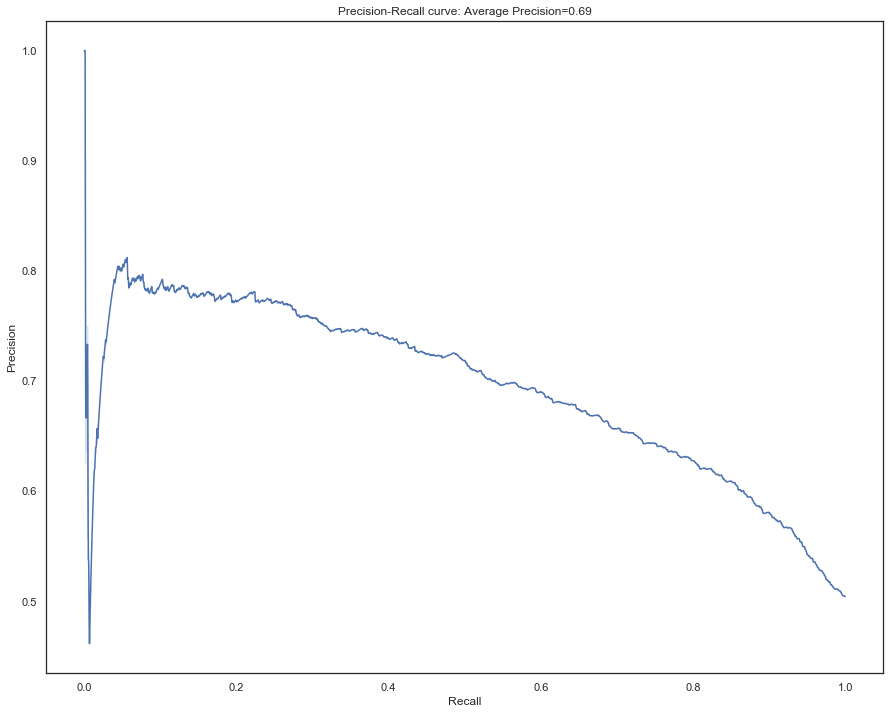

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score

features = [f for f in model_columns if f not in {'summary_date','avg_sleep_score_next_week_binarized','avg_sleep_score_next_week'}]

logistic_model = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='lbfgs', multi_class='ovr'))

logistic_model.fit(train[features],train['avg_sleep_score_next_week_binarized'])

precision, recall, thresholds = precision_recall_curve(
    test['avg_sleep_score_next_week_binarized'], 
    logistic_model.predict_proba(test[features])[:,1]
)


average_precision = average_precision_score(test['avg_sleep_score_next_week_binarized'], 
    logistic_model.predict_proba(test[features])[:,1]
                                           )
pr_df = pd.DataFrame({'precision':precision,'recall':recall})

sns.set(style="white", color_codes=True)
fig, ax = plt.subplots(1,1,figsize=(15,12))
ax = sns.lineplot(x='recall', y= 'precision', data=pr_df)
ax.set(xlabel='Recall', ylabel= 'Precision')
ax.set_title('Precision-Recall curve: Average Precision={0:0.2f}'.format(
          average_precision))

##### Baseline vs Selected Features Comparison using a RANDOM FOREST Model

In [38]:
benchmarker(data_set = df_gold,model = RandomForestRegressor(),
            model_evaluator = 'median_absolute_error',variable_set = model_columns)

AttributeError: 'Series' object has no attribute 'reshape'

our baseline random forest model seems to consistently outperform the selected random forest model using median absolute error as an evaluation metric

### Recommendation for Increasing the Odds of Better Avg Sleep over Next 7 Days

We can handle users who don't exist in our training set by uniformly distributing the coefficients of all users who do exists in our training set/model. Essentially, each user_id indicator gets weighted by 1/n users_ids so that the user who doesn't exists gets the average of the coefficients.

In [39]:

def userCheck(userData):
    '''takes the feature transformed user data; the data should be from the most recent date
    the data is available'''
    
    #check if user exists in the model
    if userData.filter(user_dummies_cols).values[0].sum():
        return userData
    else: 
        #uniformly distribute coefficients of user id's in the model if current user doesn't exist in model
        val = 1/len(user_dummies_cols)
        #assign this value to each user_id dummy variable
        for usr in user_dummies_cols:
            userData[usr] = val

        return userData


#Ed's userID is TE2CPSSWP4QUGFAJQZ5FHITIKPNCCICX
ed_data = mod_df[(mod_df['user_id_TE2CPSSWP4QUGFAJQZ5FHITIKPNCCICX'] == 1) & (mod_df['summary_date'] == '2019-10-03')]\
.filter(features)
ed_data = userCheck(ed_data)

In [40]:
def odds_recommender(model,user_data):
    from copy import deepcopy
    '''returns a dataframe in the format of feature, adjusted odds of improving avg sleep score in next 7 days
    and the description of how to do so'''
    
    actionable_features = ['rol_bedtime_start_delta_7d','sleep_routine_score','activity_routine_score',
                        'score_training_frequency','score_training_volume',
                        'rol_steps_7d','rol_sleep_afterMidnight_7d','rol_onset_latency_7d',
                        'experiment_category_Chamomile Tea','experiment_category_Magnesium',
                        'experiment_category_Meditation','rol_met_min_high_7d']
    
    
    descriptions = {
    'sleep_routine_score':
    "stay consistent with your sleep routines: go to sleep around the same time and get the same amount of sleep each night",
    'activity_routine_score': 
    "stay consistent with your activity routines: maintain the same frequency and intensity of activity from week to week",
    'rol_score_disturbances_7d':"limit the number of times you get up and how frequently you move throughout your sleep over the next week",
    'score_training_frequency': "get more than 100 minutes of medium or high intensity activity on at least three of the next seven days",
    'score_training_volume':"attain a sum total of 750 MET minutes over the next 7 days",
    'rol_bedtime_start_delta_7d': "limit the weekly variance in the times that you fall asleep",
    'rol_steps_7d': " get an additional 2000 steps in each day over the next week",
    'rol_sleep_afterMidnight_7d': "consistently go to bed before midnight each night over the next week",
    'rol_onset_latency_7d': "aim to fall asleep on average within 15 minutes after laying in bed",
    'user baseline': "the current odds that the user has of increasing next week's avg sleep score",
    'experiment_category_Chamomile Tea': "experiment in drinking Chamomile Tea",
    'experiment_category_Magnesium': "experiment in taking Magnesium supplements",
    'experiment_category_Meditation': "experiment with Meditation",
    'rol_met_min_high_7d': "get an additional 30 minutes of high intesity activity in each day over the next week"    
    }
    
    
    base_odds = model.predict_proba(user_data)[0][1]/logistic_model.predict_proba(user_data)[0][0]
    adj_odds = []
    for a in actionable_features:
        #reset the copy on each iteration
        user_data_copy = user_data.copy()
        if a in {'rol_bedtime_start_delta_7d','sleep_routine_score','activity_routine_score'}:
            #all features above have an ideal target of 0
            user_data_copy[a] = 0
            new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
            adj_odds.append([a,new_odds])

        elif a in {'rol_score_disturbances_7d','score_training_frequency','score_training_volume'}:
            #all features above have an ideal target of 95+
            user_data_copy[a] = 95
            new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
            adj_odds.append([a,new_odds])
        elif a in {'rol_steps_7d'}:
            #1 mile is approximately 2000 steps (will increment avg by 2000)
            user_data_copy[a] = user_data_copy[a].values[0] + 2000
            new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
            adj_odds.append([a,new_odds])

        elif a == 'rol_sleep_afterMidnight_7d':
            if user_data_copy[a].values[0] > 0:
                user_data_copy[a] = 0
                new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
                adj_odds.append([a,new_odds])
        elif a == 'rol_onset_latency_7d':
                user_data_copy[a] = 900    
                new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
                adj_odds.append([a,new_odds])
                    
        elif a == 'experiment_category_Chamomile Tea':
            if user_data[a].values[0] == 0:
                user_data_copy[a] = 1    
                new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
                adj_odds.append([a,new_odds])

        elif a == 'experiment_category_Magnesium':
            if user_data[a].values[0] == 0:
                user_data_copy[a] = 1    
                new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
                adj_odds.append([a,new_odds])            
            
        elif a == 'experiment_category_Meditation':
            if user_data[a].values[0] == 0:
                user_data_copy[a] = 1    
                new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
                adj_odds.append([a,new_odds])
        elif a == 'rol_met_min_high_7d':
            user_data_copy[a] = user_data_copy[a].values[0] + 30
            new_odds = model.predict_proba(user_data_copy)[0][1]/model.predict_proba(user_data_copy)[0][0]
            adj_odds.append([a,new_odds])
            
    adj_odds.append(['user baseline',base_odds])
    
    description_list = []
    for k,v in descriptions.items():
        description_list.append([k,v])

    descript_df = pd.DataFrame(description_list,columns = ['Feature','Description'])
    
    odds_df = pd.DataFrame(adj_odds,
            columns = ['Feature','Odds of Improving Avg Sleep Quality'])
    
    return odds_df.merge(descript_df,on='Feature',how = 'left')

In [41]:
odds_recommender(model = logistic_model,user_data = ed_data)

,Feature,Odds of Improving Avg Sleep Quality,Description
0,rol_bedtime_start_delta_7d,0.813437,limit the weekly variance in the times that yo...
1,sleep_routine_score,0.795064,stay consistent with your sleep routines: go t...
2,activity_routine_score,0.795689,stay consistent with your activity routines: m...
3,score_training_frequency,1.156176,get more than 100 minutes of medium or high in...
4,score_training_volume,0.813459,attain a sum total of 750 MET minutes over the...
5,rol_steps_7d,0.793122,get an additional 2000 steps in each day over...
6,rol_onset_latency_7d,0.824957,aim to fall asleep on average within 15 minute...
7,experiment_category_Chamomile Tea,0.794881,experiment in drinking Chamomile Tea
8,experiment_category_Magnesium,0.409151,experiment in taking Magnesium supplements
9,experiment_category_Meditation,1.230505,experiment with Meditation
